In [120]:
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [90]:
def softmax(x):
  """
  Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
  """
  out_exp = np.exp(x)
  sum_out_exp = out_exp.sum(axis=1)  
  output = out_exp/sum_out_exp[:,None]  
  return output

def sigmoid(x):
  """
  General Sigmoid function
  """
  return 1./(1. + np.exp(-x))

def load_data(fname):
  """
  Write code to read the data and return it as 2 numpy arrays.
  Make sure to convert labels to one hot encoded format.
  """
  f = open(fname, 'rb')
  data = pickle.load(f)
  f.close()
  images, labels = data[:, :-1], data[:, -1]

  labels = labels.astype(np.int)
  onehotlabels = np.zeros((len(labels), labels.max()+1))
  onehotlabels[np.arange(len(labels)), labels] = 1
  return images, onehotlabels


class Activation:
  def __init__(self, activation_type = "sigmoid"):
    self.activation_type = activation_type
    self.x = None # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
  
  def forward_pass(self, a):
    if self.activation_type == "sigmoid":
      return self.sigmoid(a)
    
    elif self.activation_type == "tanh":
      return self.tanh(a)
    
    elif self.activation_type == "ReLU":
      return self.ReLU(a)
  
  def backward_pass(self, delta):
    if self.activation_type == "sigmoid":
      grad = self.grad_sigmoid()
    
    elif self.activation_type == "tanh":
      grad = self.grad_tanh()
    
    elif self.activation_type == "ReLU":
      grad = self.grad_ReLU()
    
    return grad * delta
      
  def sigmoid(self, x):
    """
    Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = sigmoid(x)
    return output

  def tanh(self, x):
    """
    Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.tanh(x)
    return output

  def ReLU(self, x):
    """
    Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.maximum(x, 0)
    return output

  def grad_sigmoid(self):
    """
    Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    sigmoid_x = sigmoid(self.x)
    grad = sigmoid_x * (1-sigmoid_x)
    return grad

  def grad_tanh(self):
    """
    Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
    """
    tanh_x = np.tanh(self.x)
    grad = 1 - (tanh_x * tanh_x)
    return grad

  def grad_ReLU(self):
    """
    Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    grad = np.where(self.x <= 0, 0, 1)
    return grad


class Layer():
  def __init__(self, in_units, out_units):
    np.random.seed(42)
    self.w = np.random.randn(in_units, out_units)  # Weight matrix
    self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
    self.x = None  # Save the input to forward_pass in this
    self.a = None  # Save the output of forward pass in this (without activation)
    self.d_x = None  # Save the gradient w.r.t x in this (AKA Delta to pass to previous layer = dE/dx)
    self.d_w = None  # Save the gradient w.r.t w in this (AKA dE/dw = Delta received . dx/dw)
    self.d_b = None  # Save the gradient w.r.t b in this (AKA dE/db = Delta received . 1)

  def forward_pass(self, x):
    """
    Write the code for forward pass through a layer. Do not apply activation function here.
    """
    self.x = x
    self.a = x @ self.w + self.b
    return self.a
  
  def backward_pass(self, delta):
    """
    Write the code for backward pass. This takes in gradient from its next layer as input,
    computes gradient for its weights and the delta to pass to its previous layers.
    """

    # This is dE/dw = delta received . dx/dw
    
    def harmadards_sum(X, Y):
      """
        X is [n, dim_x] 
        Y is [n, dim_y]
        Return the sum of all harmadard products between each vector x and y at index i to n
      """
      ans = np.zeros((X.shape[1], Y.shape[1]))
      for i in range(len(X)):
        ans += (X[i][:,None] * Y[i])
      return ans
    
    self.d_w = harmadards_sum(self.x, delta)

    # This is dE/db = delta received . 1
    self.d_b = delta.sum(axis=0)
                
    # This is delta to be passed to previous layer
    self.d_x = delta @ self.w.T
    return self.d_x

      
class Neuralnetwork():
  def __init__(self, config):
    self.layers = []
    self.x = None  # Save the input to forward_pass in this
    self.y = None  # Save the output vector of model in this
    self.targets = None  # Save the targets in forward_pass in this variable
    for i in range(len(config['layer_specs']) - 1):
      self.layers.append( Layer(config['layer_specs'][i], config['layer_specs'][i+1]) )
      
      # Unless it's output unit, add Activation layer on top
      if i < len(config['layer_specs']) - 2:
        self.layers.append(Activation(config['activation']))  
    
  def forward_pass(self, x, targets=None):
    """
    Write the code for forward pass through all layers of the model and return loss and predictions.
    If targets == None, loss should be None. If not, then return the loss computed.
    """
    self.x = x
    self.targets = targets
    
    # Input layer
    out = self.layers[0].forward_pass(x)
    
    # Forward...
    for layer in self.layers[1:]:
        out = layer.forward_pass(out)
      
    # Softmax
    self.y = softmax(out)
        
    # Cross-entropy loss
    if targets is not None:
      return self.loss_func(self.y, targets), self.y
    else:    
      return None, self.y

  def loss_func(self, logits, targets):
    '''
    find cross entropy loss between logits and targets
    '''
    output = -(targets * np.log(logits)).sum()/len(targets)
    return output
    
  def backward_pass(self):
    '''
    implement the backward pass for the whole network. 
    hint - use previously built functions.
    '''
    delta = self.targets - self.y
    
    for layer in reversed(self.layers):
      delta = layer.backward_pass(delta)
    return delta

def trainer(model, X_train, y_train, X_valid, y_valid, config):
  """
  Write the code to train the network. Use values from config to set parameters
  such as L2 penalty, number of epochs, momentum, etc.
  """
  
  BATCH_SIZE = config['batch_size']
  N_EPOCHS = config['epochs']
  LEARNING_RATE = config['learning_rate']
  
  N_BATCHES = len(X_train) // BATCH_SIZE

  EPOCHS_THRESHOLD = config['early_stop_epoch']

  USE_MOMENTUM = config['momentum']
  USE_EARLY_STOP = config['early_stop']
  
  L2_lambda = config['L2_penalty']
  
  GAMMA = 0
  if USE_MOMENTUM:
    GAMMA = config['momentum_gamma']
  
  ACTIVATION = config['activation']
  
  print("-------",
        "Model Config:",
        "\nActivation:", ACTIVATION, 
        "\nN Epoches:", N_EPOCHS, 
        "\nN Batches:",N_BATCHES, 
        "\nBatch size:", BATCH_SIZE, 
        "\nLearning rate:", LEARNING_RATE,
        "\nL2 lambda:", L2_lambda,
        "\nMomentum?", USE_MOMENTUM)
  if USE_MOMENTUM:
    print('Gamma:', GAMMA)

  best_weight_layers = []
  min_loss = float('inf')
  prev_loss = float('inf')
  consecutive_epochs = 0
  
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  
  for i_epoch in tqdm(range(N_EPOCHS)):
    
    def get_shuffle_inds():
      shuffled_inds = np.arange(len(X_train))
      np.random.shuffle(shuffled_inds)
      return shuffled_inds
    
    shuffled_inds = get_shuffle_inds()        
    
    velocities_w = {l: np.zeros_like(l.w) for l in model.layers if type(l) is Layer}
    velocities_b = {l: np.zeros_like(l.b) for l in model.layers if type(l) is Layer}
    
    for i_minibatch in range(0, len(X_train), BATCH_SIZE):
      inds_batch = shuffled_inds[i_minibatch:i_minibatch + BATCH_SIZE]
      X_batch = X_train[inds_batch]
      y_batch = y_train[inds_batch]
      
      loss, _ = model.forward_pass(X_batch, y_batch)
      delta = model.backward_pass()
            
      # Weight updates
      for l in model.layers:
        if type(l) is Layer:
          
          # To prevent confusion on sign when
          # combining with momentum/regularization
          # ------------------------------------
          
          # l.d_w and d_b is actually delta
          delta_w = l.d_w
          delta_b = l.d_b
          
          # To get gradient of loss E to w, negate it
          
          # Complete gradient of loss E with L2 Reg
          # No reg for bias
          dE_dw = (-delta_w + L2_lambda*l.w) / len(X_batch)
          dE_db = -delta_b / len(X_batch)
          
          # Apply Momentum
          prev_vw = velocities_w[l]
          current_vw = GAMMA*prev_vw + LEARNING_RATE * dE_dw
          
          prev_vb = velocities_b[l]
          current_vb = GAMMA*prev_vb + LEARNING_RATE * dE_db
          
          # Update weights
          l.w -= current_vw
          l.b -= current_vb
          
          # Save velocities
          velocities_w[l] = current_vw
          velocities_b[l] = current_vb

    # RECORD FOR REPORT
    loss_train, _ = model.forward_pass(X_train, y_train)
    loss_valid, _ = model.forward_pass(X_valid, y_valid)    
        
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    accuracy_train = test(model, X_train, y_train, config)
    accuracy_valid = test(model, X_valid, y_valid, config)
    
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy_valid)
    
    print('Epoch {} - loss train: {:4f} loss validation: {:4f} accuracy train: {:4f} accuracy validation: {:4f}'
           .format(i_epoch, loss_train, loss_valid, accuracy_train, accuracy_valid))
    
    if USE_EARLY_STOP:      
      if loss_valid < min_loss:
        min_loss = loss_valid
        best_weight_layers = model.layers
      
      if loss_valid > prev_loss:
        consecutive_epochs += 1
        if consecutive_epochs == EPOCHS_THRESHOLD:
          model.layers = best_weight_layers
          print('Stop training as validation loss increases for {} epochs'.format(EPOCHS_THRESHOLD))
          break
      else: 
        consecutive_epochs = 0
      
      prev_loss = loss_valid
  return {
    'train_losses': train_losses, 
    'valid_losses': valid_losses, 
    'train_accuracies': train_accuracies, 
    'valid_accuracies': valid_accuracies
  }
        
      
  
def test(model, X_test, y_test, config):
  """
  Write code to run the model on the data passed as input and return accuracy.
  """
  _, logits = model.forward_pass(X_test)
  predictions = np.argmax(logits, axis=1) # inds that we made predictions (0,1,2,3, ...)
  
  # convert y_test from one-hot to actual target inds
  targets = y_test.nonzero()[1]
  accuracy = (predictions == targets).sum()/len(targets)
  return accuracy

In [91]:
X_train, y_train = load_data('data/MNIST_train.pkl')
X_valid, y_valid = load_data('data/MNIST_valid.pkl')
X_test, y_test = load_data('data/MNIST_test.pkl')

In [130]:
def visualize(train, validation, title, loss=True):
    keyword = 'Loss'
    if not loss:
        keyword = 'Accuracy'
    epoch = range(len(train))
    plt.plot(epoch, train, label = 'Train {}'.format(keyword))
    plt.plot(epoch, validation, label = 'Validation {}'.format(keyword))
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(keyword)
    plt.show()

### e) Experiments with activations

In [137]:
def default_config():
    config = {}
    config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
    config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
    config['batch_size'] = 256  # Number of training samples per batch to be passed to network
    config['epochs'] = 100  # Number of epochs to train the model
    config['early_stop'] = True  # Implement early stopping or not
    config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
    config['L2_penalty'] = 0  # Regularization constant
    config['momentum'] = True  # Denotes if momentum is to be applied or not
    config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
    config['learning_rate'] = 0.05 # Learning rate of gradient descent algorithm
    return config

#### i. Sigmoid activation

In [128]:
sigmoid_conf = default_config()
sigmoid_conf['activation'] = 'sigmoid'
sigmoid_net = Neuralnetwork(sigmoid_conf)

In [129]:
sigmoid_train_stats = trainer(sigmoid_net, X_train, y_train, X_valid, y_valid, sigmoid_conf)

------- Model Config: 
Activation: sigmoid 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.04 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 1.039849 loss validation: 1.033644 accuracy train: 0.659360 accuracy validation: 0.664700
Epoch 1 - loss train: 0.805473 loss validation: 0.800015 accuracy train: 0.737560 accuracy validation: 0.739100
Epoch 2 - loss train: 0.699706 loss validation: 0.695655 accuracy train: 0.777820 accuracy validation: 0.778600
Epoch 3 - loss train: 0.635085 loss validation: 0.637658 accuracy train: 0.797360 accuracy validation: 0.796400
Epoch 4 - loss train: 0.582693 loss validation: 0.591179 accuracy train: 0.818140 accuracy validation: 0.814300
Epoch 5 - loss train: 0.548380 loss validation: 0.558803 accuracy train: 0.829780 accuracy validation: 0.826900
Epoch 6 - loss train: 0.520643 loss validation: 0.535936 accuracy train: 0.839100 accuracy validation: 0.835100
Epoch 7 - loss train: 0.499033 loss validation: 0.514344 accuracy train: 0.846260 accuracy validation: 0.841200
Epoch 8 - loss train: 0.473406 loss validation: 0.490779 accuracy train: 0.855420 accuracy validation: 0

Epoch 73 - loss train: 0.215182 loss validation: 0.289724 accuracy train: 0.936040 accuracy validation: 0.916400
Epoch 74 - loss train: 0.215337 loss validation: 0.292244 accuracy train: 0.937340 accuracy validation: 0.915200
Epoch 75 - loss train: 0.212063 loss validation: 0.290049 accuracy train: 0.937640 accuracy validation: 0.915900
Epoch 76 - loss train: 0.210367 loss validation: 0.289147 accuracy train: 0.937760 accuracy validation: 0.914500
Epoch 77 - loss train: 0.210768 loss validation: 0.288683 accuracy train: 0.936940 accuracy validation: 0.914700
Epoch 78 - loss train: 0.211923 loss validation: 0.288658 accuracy train: 0.936340 accuracy validation: 0.914900
Epoch 79 - loss train: 0.207969 loss validation: 0.287732 accuracy train: 0.938680 accuracy validation: 0.915900
Epoch 80 - loss train: 0.206555 loss validation: 0.284717 accuracy train: 0.939360 accuracy validation: 0.917900
Epoch 81 - loss train: 0.206531 loss validation: 0.285480 accuracy train: 0.939220 accuracy vali

In [132]:
print("test accuracy for sigmoid activation: ", test(sigmoid_net, X_test, y_test, sigmoid_conf))

test accuracy for sigmoid activation:  0.924


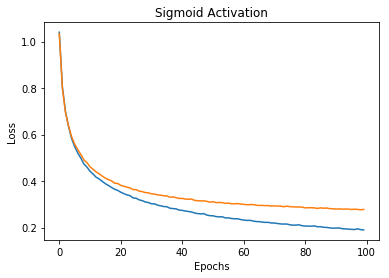

In [133]:
visualize(sigmoid_train_stats['train_losses'], sigmoid_train_stats['valid_losses'], "Sigmoid Activation")

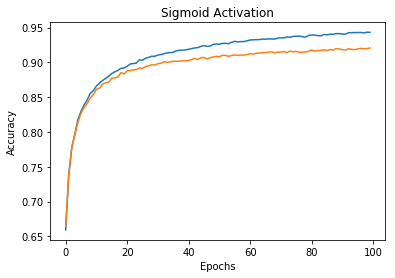

In [134]:
visualize(sigmoid_train_stats['train_accuracies'], sigmoid_train_stats['valid_accuracies'], "Sigmoid Activation", False)

#### ii. ReLU activation

In [176]:
relu_conf = default_config()
relu_conf['activation'] = 'ReLU'
relu_net = Neuralnetwork(relu_conf)

In [177]:
relu_train_stats = trainer(relu_net, X_train, y_train, X_valid, y_valid, relu_conf)

------- Model Config: 
Activation: ReLU 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 2.299486 loss validation: 2.301110 accuracy train: 0.112920 accuracy validation: 0.113700
Epoch 1 - loss train: 2.283063 loss validation: 2.280464 accuracy train: 0.123500 accuracy validation: 0.125300
Epoch 2 - loss train: 2.134919 loss validation: 2.129761 accuracy train: 0.195520 accuracy validation: 0.200700
Epoch 3 - loss train: 2.033547 loss validation: 2.041324 accuracy train: 0.249080 accuracy validation: 0.252600
Epoch 4 - loss train: 1.908430 loss validation: 1.910159 accuracy train: 0.296420 accuracy validation: 0.303300
Epoch 5 - loss train: 1.842436 loss validation: 1.839595 accuracy train: 0.332360 accuracy validation: 0.340500
Epoch 6 - loss train: 1.848992 loss validation: 1.831811 accuracy train: 0.322440 accuracy validation: 0.332200
Epoch 7 - loss train: 1.841277 loss validation: 1.849805 accuracy train: 0.320420 accuracy validation: 0.324800
Epoch 8 - loss train: 1.581463 loss validation: 1.570852 accuracy train: 0.397000 accuracy validation: 0

Epoch 73 - loss train: 0.694554 loss validation: 0.714550 accuracy train: 0.788320 accuracy validation: 0.783400
Epoch 74 - loss train: 0.682992 loss validation: 0.702476 accuracy train: 0.796340 accuracy validation: 0.791300
Epoch 75 - loss train: 0.740644 loss validation: 0.757173 accuracy train: 0.782080 accuracy validation: 0.783100
Epoch 76 - loss train: 0.709682 loss validation: 0.729078 accuracy train: 0.783880 accuracy validation: 0.779200
Epoch 77 - loss train: 0.728371 loss validation: 0.744843 accuracy train: 0.788160 accuracy validation: 0.787200
Epoch 78 - loss train: 0.668258 loss validation: 0.680363 accuracy train: 0.801360 accuracy validation: 0.797400
Epoch 79 - loss train: 0.723990 loss validation: 0.747638 accuracy train: 0.786060 accuracy validation: 0.786500
Epoch 80 - loss train: 0.700648 loss validation: 0.717617 accuracy train: 0.784520 accuracy validation: 0.781000
Epoch 81 - loss train: 0.728269 loss validation: 0.753251 accuracy train: 0.781560 accuracy vali

In [178]:
print("test accuracy for ReLU activation: ", test(relu_net, X_test, y_test, relu_conf))

test accuracy for ReLU activation:  0.7939


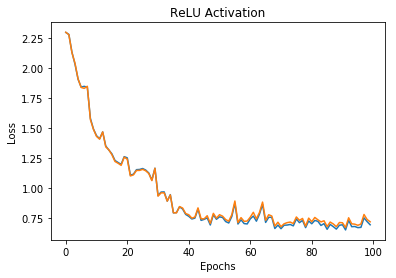

In [179]:
visualize(relu_train_stats['train_losses'], relu_train_stats['valid_losses'], "ReLU Activation")

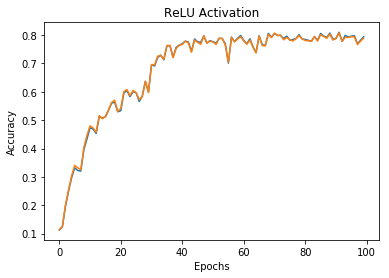

In [180]:
visualize(relu_train_stats['train_accuracies'], relu_train_stats['valid_accuracies'], "ReLU Activation", False)

In [158]:
relu_conf2 = default_config()
relu_conf2['activation'] = 'ReLU'
relu_conf2['layer_specs'] = [784, 100, 10]
relu_conf2['learning_rate'] = 0.005
relu_net2 = Neuralnetwork(relu_conf2)

In [159]:
relu_train_stats2 = trainer(relu_net2, X_train, y_train, X_valid, y_valid, relu_conf2)

------- Model Config: 
Activation: ReLU 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.005 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


/Users/ntemiyasathit/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in log
/Users/ntemiyasathit/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in multiply


Epoch 0 - loss train: 2.905662 loss validation: 2.886562 accuracy train: 0.691060 accuracy validation: 0.697600
Epoch 1 - loss train: 1.662351 loss validation: 1.668120 accuracy train: 0.673900 accuracy validation: 0.675300
Epoch 2 - loss train: 1.310842 loss validation: 1.345001 accuracy train: 0.704560 accuracy validation: 0.701400
Epoch 3 - loss train: 1.134925 loss validation: 1.178869 accuracy train: 0.719580 accuracy validation: 0.717100
Epoch 4 - loss train: 1.020647 loss validation: 1.065063 accuracy train: 0.736960 accuracy validation: 0.736900
Epoch 5 - loss train: 0.935261 loss validation: 0.980952 accuracy train: 0.751040 accuracy validation: 0.751500
Epoch 6 - loss train: 0.871326 loss validation: 0.916518 accuracy train: 0.763080 accuracy validation: 0.762900
Epoch 7 - loss train: 0.814146 loss validation: 0.856428 accuracy train: 0.774340 accuracy validation: 0.774900
Epoch 8 - loss train: 0.767835 loss validation: 0.809599 accuracy train: 0.782660 accuracy validation: 0

Epoch 73 - loss train: 0.316693 loss validation: 0.371078 accuracy train: 0.901260 accuracy validation: 0.897600
Epoch 74 - loss train: 0.319793 loss validation: 0.373465 accuracy train: 0.899760 accuracy validation: 0.898000
Epoch 75 - loss train: 0.322553 loss validation: 0.375537 accuracy train: 0.900320 accuracy validation: 0.899100
Epoch 76 - loss train: 0.315378 loss validation: 0.368384 accuracy train: 0.902060 accuracy validation: 0.899600
Epoch 77 - loss train: 0.314543 loss validation: 0.371228 accuracy train: 0.901820 accuracy validation: 0.900500
Epoch 78 - loss train: 0.315825 loss validation: 0.371150 accuracy train: 0.902000 accuracy validation: 0.899800
Epoch 79 - loss train: 0.315085 loss validation: 0.369091 accuracy train: 0.903260 accuracy validation: 0.901100
Epoch 80 - loss train: 0.308022 loss validation: 0.365525 accuracy train: 0.904500 accuracy validation: 0.900200
Epoch 81 - loss train: 0.313175 loss validation: 0.371393 accuracy train: 0.902340 accuracy vali

In [173]:
print("test accuracy for ReLU activation (conf 2): ", test(relu_net2, X_test, y_test, relu_conf2))

test accuracy for ReLU activation (conf 2):  0.9047


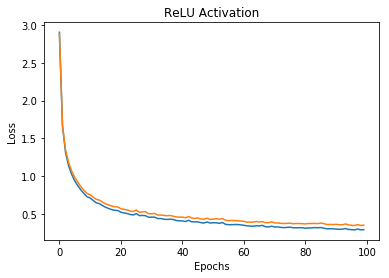

In [174]:
visualize(relu_train_stats2['train_losses'], relu_train_stats2['valid_losses'], "ReLU Activation with hyper-param tuned")

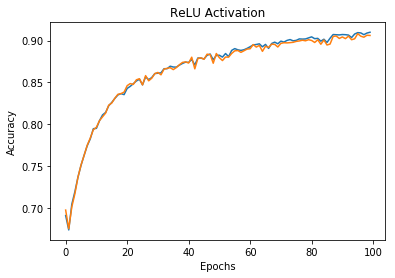

In [175]:
visualize(relu_train_stats2['train_accuracies'], relu_train_stats2['valid_accuracies'], "ReLU Activation with hyper-param tuned", False)

### f) Experiments with network topology

#### i. Half and double hidden units

In [112]:
half_conf = default_config()
half_conf['layer_specs'] = [784, 25, 10]
half_net = Neuralnetwork(half_conf)

In [113]:
half_train_stats = trainer(half_net, X_train, y_train, X_valid, y_valid, half_conf)

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 1.149170 loss validation: 1.138896 accuracy train: 0.614120 accuracy validation: 0.616700
Epoch 1 - loss train: 0.929077 loss validation: 0.932047 accuracy train: 0.701320 accuracy validation: 0.701300
Epoch 2 - loss train: 0.796819 loss validation: 0.792749 accuracy train: 0.746600 accuracy validation: 0.748100
Epoch 3 - loss train: 0.714552 loss validation: 0.717745 accuracy train: 0.775580 accuracy validation: 0.776900
Epoch 4 - loss train: 0.651793 loss validation: 0.664137 accuracy train: 0.797400 accuracy validation: 0.796300
Epoch 5 - loss train: 0.615957 loss validation: 0.632418 accuracy train: 0.806520 accuracy validation: 0.801000
Epoch 6 - loss train: 0.582491 loss validation: 0.596741 accuracy train: 0.822700 accuracy validation: 0.819400
Epoch 7 - loss train: 0.555441 loss validation: 0.578129 accuracy train: 0.832580 accuracy validation: 0.826800
Epoch 8 - loss train: 0.529727 loss validation: 0.556073 accuracy train: 0.843040 accuracy validation: 0

Epoch 73 - loss train: 0.304122 loss validation: 0.377153 accuracy train: 0.910200 accuracy validation: 0.890700
Epoch 74 - loss train: 0.295396 loss validation: 0.381024 accuracy train: 0.913640 accuracy validation: 0.891500
Epoch 75 - loss train: 0.294541 loss validation: 0.381924 accuracy train: 0.913200 accuracy validation: 0.891500
Epoch 76 - loss train: 0.288071 loss validation: 0.378345 accuracy train: 0.915600 accuracy validation: 0.892200
Epoch 77 - loss train: 0.289380 loss validation: 0.380079 accuracy train: 0.914680 accuracy validation: 0.891000
Epoch 78 - loss train: 0.289038 loss validation: 0.377361 accuracy train: 0.913820 accuracy validation: 0.890300
Epoch 79 - loss train: 0.285508 loss validation: 0.375617 accuracy train: 0.916480 accuracy validation: 0.891100
Epoch 80 - loss train: 0.282103 loss validation: 0.376448 accuracy train: 0.918260 accuracy validation: 0.892500
Epoch 81 - loss train: 0.286364 loss validation: 0.379037 accuracy train: 0.916420 accuracy vali

In [124]:
print("test accuracy for half hidden units: ", test(half_net, X_test, y_test, half_conf))

test accuracy for half hidden units:  0.9034


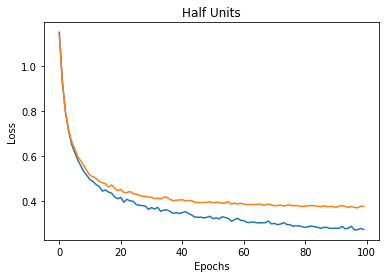

In [144]:
visualize(half_train_stats['train_losses'], half_train_stats['valid_losses'], "Half Units")

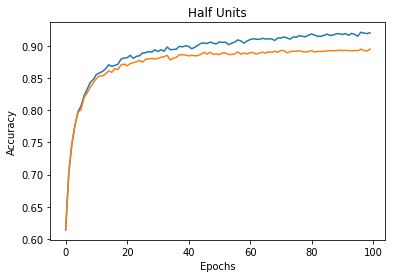

In [145]:
visualize(half_train_stats['train_accuracies'], half_train_stats['valid_accuracies'], "Half Units", False)

In [161]:
double_conf = default_config()
double_conf['layer_specs'] = [784, 200, 10]
double_net = Neuralnetwork(double_conf)

In [162]:
double_train_stats = trainer(double_net, X_train, y_train, X_valid, y_valid, double_conf)

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 0.890110 loss validation: 0.960672 accuracy train: 0.787040 accuracy validation: 0.778100
Epoch 1 - loss train: 0.630314 loss validation: 0.708937 accuracy train: 0.826340 accuracy validation: 0.816000
Epoch 2 - loss train: 0.512291 loss validation: 0.600088 accuracy train: 0.855040 accuracy validation: 0.840000
Epoch 3 - loss train: 0.446748 loss validation: 0.528215 accuracy train: 0.869140 accuracy validation: 0.854100
Epoch 4 - loss train: 0.418629 loss validation: 0.507537 accuracy train: 0.874420 accuracy validation: 0.860200
Epoch 5 - loss train: 0.370611 loss validation: 0.463517 accuracy train: 0.888260 accuracy validation: 0.873700
Epoch 6 - loss train: 0.352325 loss validation: 0.452493 accuracy train: 0.892780 accuracy validation: 0.874100
Epoch 7 - loss train: 0.343183 loss validation: 0.435962 accuracy train: 0.895280 accuracy validation: 0.878200
Epoch 8 - loss train: 0.314253 loss validation: 0.409776 accuracy train: 0.903640 accuracy validation: 0

Epoch 73 - loss train: 0.094186 loss validation: 0.328729 accuracy train: 0.973400 accuracy validation: 0.919300
Epoch 74 - loss train: 0.093562 loss validation: 0.333519 accuracy train: 0.974000 accuracy validation: 0.918100
Epoch 75 - loss train: 0.090599 loss validation: 0.331813 accuracy train: 0.975000 accuracy validation: 0.918900
Epoch 76 - loss train: 0.092394 loss validation: 0.331685 accuracy train: 0.974060 accuracy validation: 0.920000
Epoch 77 - loss train: 0.089136 loss validation: 0.329113 accuracy train: 0.975780 accuracy validation: 0.918900
Epoch 78 - loss train: 0.088225 loss validation: 0.330773 accuracy train: 0.975520 accuracy validation: 0.919600
Epoch 79 - loss train: 0.086363 loss validation: 0.331809 accuracy train: 0.976540 accuracy validation: 0.920600
Epoch 80 - loss train: 0.087864 loss validation: 0.333592 accuracy train: 0.975680 accuracy validation: 0.919700
Epoch 81 - loss train: 0.088854 loss validation: 0.336758 accuracy train: 0.974740 accuracy vali

In [169]:
print("test accuracy for double hidden units: ", test(double_net, X_test, y_test, double_conf))

test accuracy for double hidden units:  0.9294


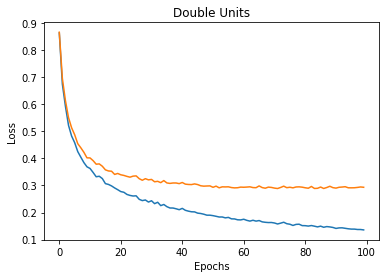

In [170]:
visualize(doublt_train_stats['train_losses'], doublt_train_stats['valid_losses'], "Double Units")

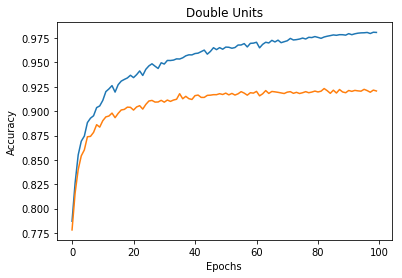

In [171]:
visualize(double_train_stats['train_accuracies'], double_train_stats['valid_accuracies'], "Double Units", False)

#### ii. More hidden units

In [116]:
new_conf = default_config()
new_conf['layer_specs'] = [784, 50, 50, 10]
new_net = Neuralnetwork(new_conf)

In [117]:
new_train_stats = trainer(new_net, X_train, y_train, X_valid, y_valid, new_conf)

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch 0 - loss train: 1.044683 loss validation: 1.020386 accuracy train: 0.659740 accuracy validation: 0.669100
Epoch 1 - loss train: 0.839669 loss validation: 0.822431 accuracy train: 0.727600 accuracy validation: 0.732700
Epoch 2 - loss train: 0.739610 loss validation: 0.731449 accuracy train: 0.764740 accuracy validation: 0.764100
Epoch 3 - loss train: 0.665378 loss validation: 0.651532 accuracy train: 0.790640 accuracy validation: 0.795400
Epoch 4 - loss train: 0.621435 loss validation: 0.609687 accuracy train: 0.808160 accuracy validation: 0.809700
Epoch 5 - loss train: 0.553061 loss validation: 0.552086 accuracy train: 0.829160 accuracy validation: 0.828600
Epoch 6 - loss train: 0.530106 loss validation: 0.535361 accuracy train: 0.838520 accuracy validation: 0.837000
Epoch 7 - loss train: 0.497538 loss validation: 0.520965 accuracy train: 0.847680 accuracy validation: 0.840100
Epoch 8 - loss train: 0.469206 loss validation: 0.487697 accuracy train: 0.856300 accuracy validation: 0

Epoch 73 - loss train: 0.181946 loss validation: 0.303289 accuracy train: 0.945980 accuracy validation: 0.916500
Epoch 74 - loss train: 0.189663 loss validation: 0.301462 accuracy train: 0.943900 accuracy validation: 0.919900
Epoch 75 - loss train: 0.182172 loss validation: 0.300698 accuracy train: 0.946600 accuracy validation: 0.919100
Epoch 76 - loss train: 0.175714 loss validation: 0.302585 accuracy train: 0.947820 accuracy validation: 0.918800
Epoch 77 - loss train: 0.182899 loss validation: 0.300428 accuracy train: 0.946460 accuracy validation: 0.920800
Epoch 78 - loss train: 0.173560 loss validation: 0.295645 accuracy train: 0.950660 accuracy validation: 0.920800
Epoch 79 - loss train: 0.172336 loss validation: 0.297396 accuracy train: 0.950240 accuracy validation: 0.921700
Epoch 80 - loss train: 0.178195 loss validation: 0.299091 accuracy train: 0.947540 accuracy validation: 0.919900
Epoch 81 - loss train: 0.175178 loss validation: 0.300440 accuracy train: 0.948480 accuracy vali

In [172]:
print("test accuracy for 2 hidden layers: ", test(new_net, X_test, y_test, new_conf))

test accuracy for 2 hidden layers:  0.9203


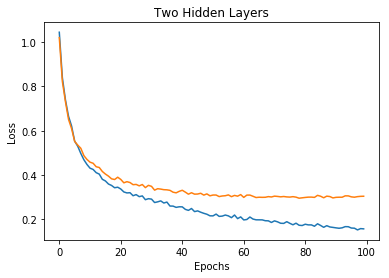

In [167]:
visualize(new_train_stats['train_losses'], new_train_stats['valid_losses'], "Two Hidden Layers")

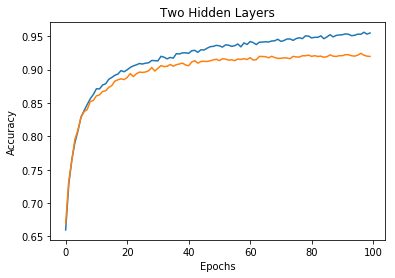

In [168]:
visualize(new_train_stats['train_accuracies'], new_train_stats['valid_accuracies'], "Two Hidden Layers", False)

In [181]:
three_conf = default_config()
three_conf['layer_specs'] = [784, 50, 50, 50, 10]
three_net = Neuralnetwork(three_conf)

In [ ]:
three_train_stats = trainer(three_net, X_train, y_train, X_valid, y_valid, three_conf)

In [ ]:
print("test accuracy for 2 hidden layers: ", test(three_net, X_test, y_test, three_conf))

In [ ]:
visualize(three_train_stats['train_losses'], three_train_stats['valid_losses'], "Three Hidden Layers")

In [ ]:
visualize(three_train_stats['train_accuracies'], three_train_stats['valid_accuracies'], "Three Hidden Layers", False)